# Pandas time series - example 1

## Monthly averaged historical temperatures in France and over the global land surface

The aim of this notebook is just to play with time series along with a couple of statistical and plotting libraries.

### Imports

In [1]:
%matplotlib inline
import pandas as pd  # 0.23.0
import numpy as np
import matplotlib.pyplot as plt  # 2.2.2
import seaborn as sns  # 0.8.1
from statsmodels.tsa.stattools import adfuller  # 0.9.0
import statsmodels.api as sm

### Loading the data

Historical monthly average temperature in France from the [World Bank Group](http://sdwebx.worldbank.org/climateportal/index.cfm).

> Historical data to understand the seasonal CYCLE: This gridded historical dataset is derived from observational data, and provides quality controlled temperature and rainfall values from thousands of weather stations worldwide, as well as derivative products including monthly climatologies and long term historical climatologies. The dataset is produced by the Climatic Research Unit (CRU) of University of East Anglia (UEA), and reformatted by International Water Management Institute (IWMI). CRU-(Gridded Product). CRU data can be mapped to show the baseline climate and seasonality by month, for specific years, and for rainfall and temperature.

The data was loaded into a spreadsheet and then exported as a csv file, after changing decimal separator from comma to point and removing useless columns (country code).

In [2]:
temperature = pd.read_csv('data/tas_1901_2015_France.csv')
temperature.head()

,tas,Year,Month
0,3.25950,1901,1
1,0.32148,1901,2
2,4.82373,1901,3
3,9.38568,1901,4
4,12.69960,1901,5


In [3]:
print(len(temperature), "rows")
print("column types :\n", temperature.dtypes)

1380 rows
column types :
 tas      float64
Year       int64
Month      int64
dtype: object


### Creating a DatetimeIndex

Pandas'`to_datetime()` method requires at least the `year`, `month` and `day` columns (in lower case). So we rename the `Year` and `Month` columns and create a `day` column arbitrarily set to the 15th of each month.

In [4]:
temperature.rename(columns={'Year': 'year', 'Month': 'month'}, inplace=True)
temperature["day"] = 15
temperature.head()

,tas,year,month,day
0,3.25950,1901,1,15
1,0.32148,1901,2,15
2,4.82373,1901,3,15
3,9.38568,1901,4,15
4,12.69960,1901,5,15


Now we can apply the `to_datetime()` method, change the index and clean the dataframe.

In [5]:
temperature["Date"] = pd.to_datetime(temperature[['year', 'month', 'day']])
temperature.set_index("Date", inplace=True)
temperature.drop(['year', 'month', 'day'], axis=1, inplace=True)
temperature.head()

,tas
Date,
1901-01-15,3.25950
1901-02-15,0.32148
1901-03-15,4.82373
1901-04-15,9.38568
1901-05-15,12.69960


Plotting these monthly averaged temperatures is rather messy because of seasonal fluctuations.

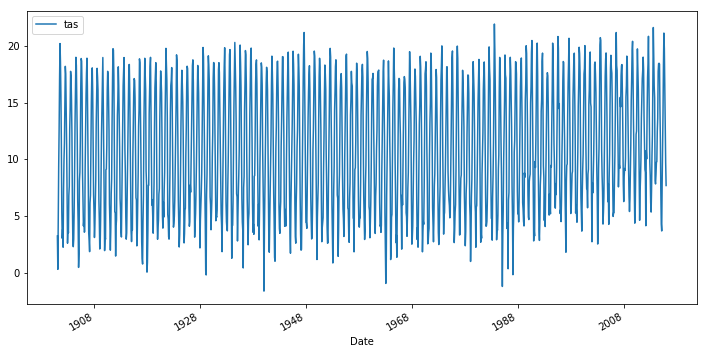

In [6]:
temperature.plot(figsize=(12, 6))

Note that we could also have created a `PeriodIndex` with a monthy frequency:
```python
temperature = temperature.to_period(freq='M')
```

However this seems to be less handy for resampling operations.

### Resampling

First thing we can do is to compute the annual `mean`, `min` and `max`. The `resample()` method is used with the 'AS' offset, which corresponds to the year start frequency (see [this](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases) following documentation for the whole list of rules).

In [7]:
temp_annual = temperature.resample("AS").agg(['mean', 'min', 'max'])

In [8]:
temp_annual.head(5)

tas                  
                 mean      min      max
Date                                   
1901-01-01  10.177163  0.32148  20.1921
1902-01-01   9.991733  2.26860  18.1870
1903-01-01  10.070277  2.95230  17.7461
1904-01-01  10.307586  2.31437  18.9831
1905-01-01   9.982693  0.49251  18.8757

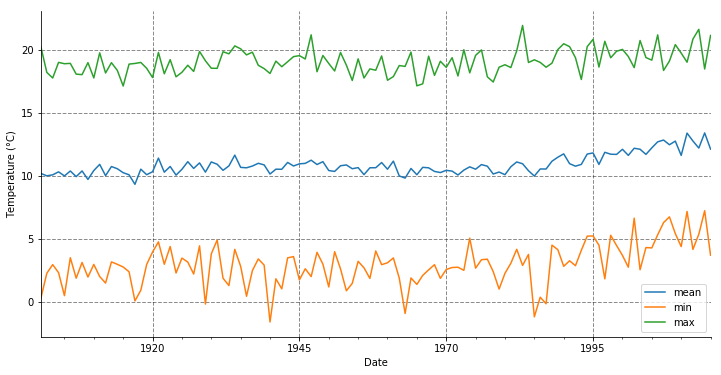

In [9]:
temp_annual.tas.plot(figsize=(12, 6))
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
sns.despine()

### Rolling window mean

Next we compute a centered rolling window mean with 10 years windows and an exponentially-weighted moving average with a 2 years half life. 

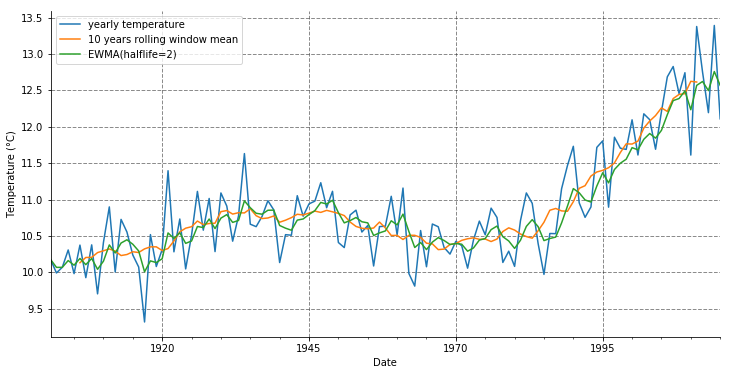

In [10]:
temp_annual[('tas', 'mean')].plot(label='yearly temperature', figsize=(12, 6))
temp_annual[('tas', 'mean')].rolling(10, center=True).mean().plot(label='10 years rolling window mean')
temp_annual[('tas', 'mean')].ewm(halflife=2).mean().plot(label='EWMA(halflife=2)')  # Exponentially-weighted moving average
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.ylabel("Temperature (°C)")
sns.despine()

We can also compute and plot the standard deviation of the data over the rolling window.

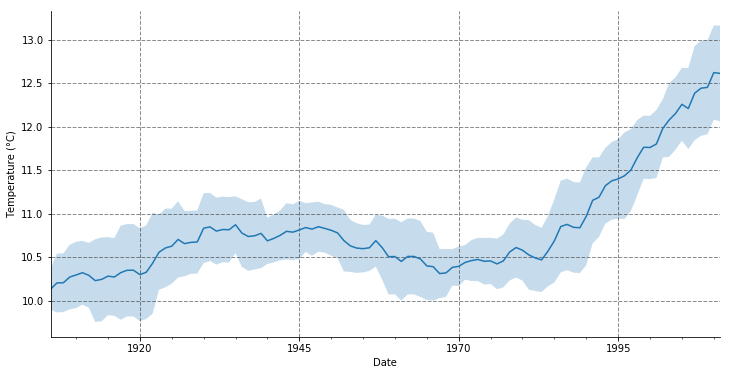

In [11]:
m = temp_annual[('tas', 'mean')].rolling(10, center=True).agg(['mean', 'std'])
ax = m['mean'].plot(label='10 years rolling window mean', figsize=(12, 6))
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
sns.despine()

### Checking for Stationarity

Well I am not very familiar with Statistics related with time series, so I just grabbed something that looks fancy on [this](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) page :) This is the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) from [StatsModels](https://www.statsmodels.org/stable/index.html).

Let us apply this test to the original monthly temperature dataframe. First we convert it into a time `Series`.

In [12]:
ts = pd.Series(temperature.tas, index=temperature.index)
ts.head()

Date
1901-01-15     3.25950
1901-02-15     0.32148
1901-03-15     4.82373
1901-04-15     9.38568
1901-05-15    12.69960
Name: tas, dtype: float64

Then we perform the test:

In [13]:
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -1.651531
p-value                           0.456242
#Lags Used                       24.000000
Number of Observations Used    1355.000000
Critical Value (1%)              -3.435185
Critical Value (5%)              -2.863675
Critical Value (10%)             -2.567907
dtype: float64


We already saw that the mean is clearly increasing starting in the 80s while standard deviation seems to be uniform. Now we can observe that the Test Statistic is significantly greater than the critical values and that the p-value is not so small, which also seems to indicate that the data is not stationary.

Let us try to make this time series artificially stationary by removing the rolling mean from the data and run the test again. We start by computing the mean on a 120 months rolling window.

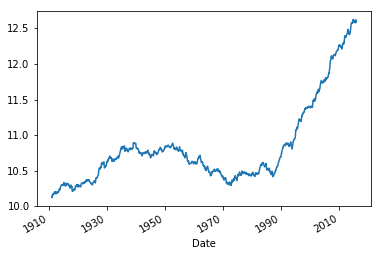

In [14]:
ts_mean = ts.rolling(window=120).mean().rename("t_mean")
ts_mean.plot()

Note that there are `NaN` values at the begining of the serie because the there is not enough data in the rolling window.

In [15]:
ts_mean.head()

Date
1901-01-15   NaN
1901-02-15   NaN
1901-03-15   NaN
1901-04-15   NaN
1901-05-15   NaN
Name: t_mean, dtype: float64

Now we merge the mean temperature with the original monthly temperature and compute the "corrected" temperature `t_modified`.

In [16]:
stat_temp = pd.merge(temperature, ts_mean.to_frame(), 
                     left_index=True, right_index=True, how='inner').dropna()
stat_temp["t_modified"] = stat_temp["tas"]-stat_temp["t_mean"]+stat_temp["t_mean"][0]

Let us re-compute the rolling mean for original and modified data.

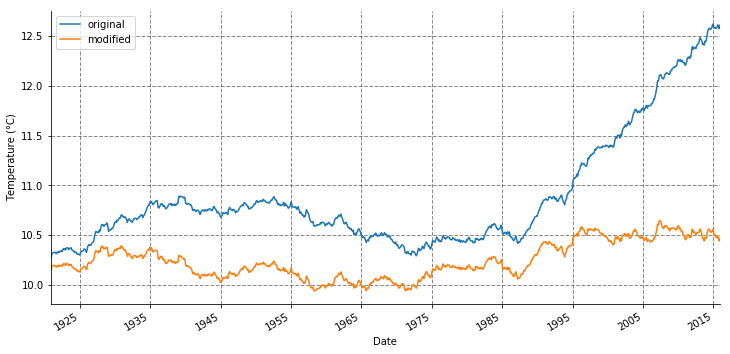

In [17]:
stat_temp.tas.rolling(window=120).mean().plot(label='original', figsize=(12, 6))
stat_temp.t_modified.rolling(window=120).mean().plot(label='modified')
ax = plt.gca()
ax.grid(color=(0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.ylabel("Temperature (°C)")
sns.despine()

Now we run the Dickey–Fuller test again, on the modified data.

In [18]:
ts2 = pd.Series(stat_temp.t_modified, index=stat_temp.index)
ts2.head()

Date
1910-12-15    4.385380
1911-01-15    2.021325
1911-02-15    3.879265
1911-03-15    6.911458
1911-04-15    8.259301
Name: t_modified, dtype: float64

In [19]:
dftest = adfuller(ts2, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -5.913709e+00
p-value                        2.602534e-07
#Lags Used                     2.300000e+01
Number of Observations Used    1.237000e+03
Critical Value (1%)           -3.435647e+00
Critical Value (5%)           -2.863879e+00
Critical Value (10%)          -2.568015e+00
dtype: float64


This time the data is found to be stationary (Test Statistic is lower than the critical values and small p_value), which is not a big surprise...

We should probably consider a longer time span when testing for the unstationarity of temperature.

### Comparison with global land temperature

We are now going to compare France against global land's temperatures, taken from Berkeley Earth's [website](http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt).

In [20]:
glt = pd.read_csv('data/Complete_TAVG_complete.txt', delim_whitespace=True, skiprows=33).iloc[:,0:4]
glt.columns = ['year', 'month', 'Anomaly', 'Unc'] 
glt.head()

,year,month,Anomaly,Unc
0,1750,1,0.382,NaN
1,1750,2,0.539,NaN
2,1750,3,0.574,NaN
3,1750,4,0.382,NaN
4,1750,5,NaN,NaN


Let us list the years with `NaN` values in the Anomaly column.

In [21]:
gby = glt[['year', 'Anomaly']].groupby('year').count()
gby[gby.Anomaly<12]

,Anomaly
year,
1750,4
1751,1
1752,6
2017,7


As we can see monthly Anomaly data are complete between 1753 and 2016.

In [22]:
glt = glt.loc[(glt.year >= 1753) & (glt.year <= 2016)]

Estimated Jan 1951-Dec 1980 monthly absolute temperature, copied from the file header:

In [23]:
mat = pd.DataFrame({
    'month': np.arange(1, 13),
    't_abs': [2.62, 3.23, 5.33, 8.36, 11.37, 13.53, 14.41, 13.93, 12.12, 9.26, 6.12, 3.67]})
#    'unc': [0.08, 0.07, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.06, 0.07, 0.08]})

Let us merge the absolute temperature with the Anomaly.

In [24]:
glt = pd.merge(glt, mat, on='month', how='left')
glt['t'] = glt.t_abs + glt.Anomaly

And create a `DatetimeIndex`.

In [25]:
glt['day'] = 15
glt["Date"] = pd.to_datetime(glt[['year', 'month', 'day']])
glt.set_index("Date", inplace=True)
glt.drop(['year', 'month', 'day'], axis=1, inplace=True)
glt.head()

,Anomaly,Unc,t_abs,t
Date,,,,
1753-01-15,-1.108,3.646,2.62,1.512
1753-02-15,-1.652,4.461,3.23,1.578
1753-03-15,1.020,3.623,5.33,6.350
1753-04-15,-0.557,3.898,8.36,7.803
1753-05-15,0.399,1.652,11.37,11.769


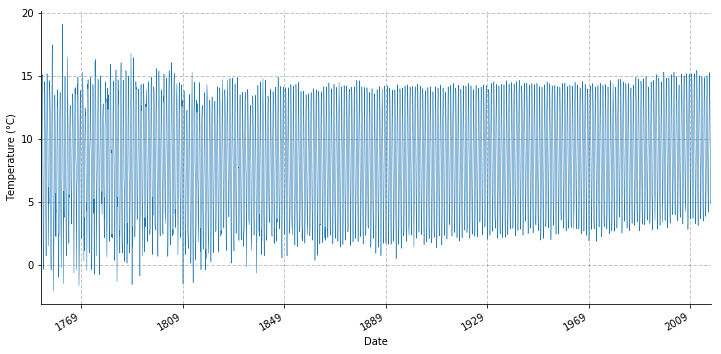

In [26]:
glt.t.plot(figsize=(12, 6), linewidth=0.5)
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
sns.despine()

Now we resample the data to a yearly frequency.

In [27]:
glty = glt.resample("AS").agg(['mean', 'min', 'max'])

Let us plot these yearly averaged temperature along with the 95% confidence interval.

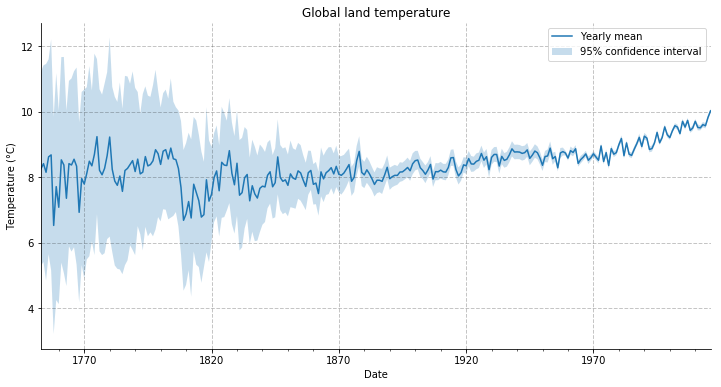

In [28]:
glty[('t', 'mean')].plot(figsize=(12, 6), label='Yearly mean')
ax = plt.gca()
ax.fill_between(glty.index, glty[('t', 'mean')] - 0.95*glty[('Unc', 'mean')], 
                            glty[('t', 'mean')] +  0.95*glty[('Unc', 'mean')], alpha=.25, label='95% confidence interval')
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
plt.title('Global land temperature')
plt.legend()
sns.despine()

Now we plot both France's and global land's yearly mean.

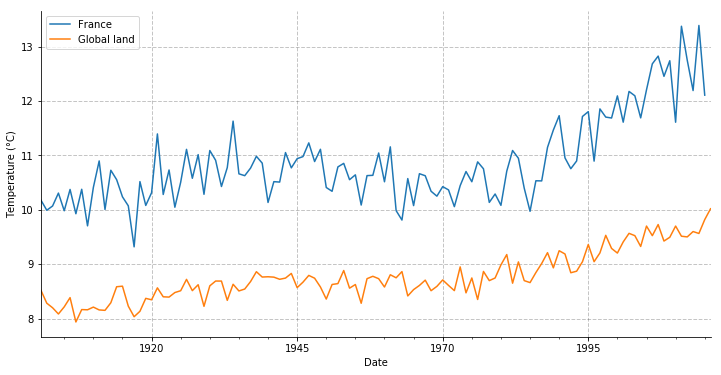

In [29]:
temp_annual[('tas', 'mean')].plot(figsize=(12, 6), label='France')
glty.loc[glty.index >= temp_annual.index.min(), ('t', 'mean')].plot(label='Global land')
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
plt.legend()
sns.despine()

Well it seems like France is getting warmer faster than the average land surface.

### Average increasing rates

Now let's try to perform a linear regression on both temperature data between 1975 and 2015-2016.
In order to use OLS from statsmodels, we need to convert the `datetime` objects into real numbers. We do so using the `to_julian_date` tool. We also add a constant term since we need an intercept.

In [30]:
df_france = temp_annual.loc[temp_annual.index >= pd.Timestamp('1975-01-01'), ('tas', 'mean')].copy(deep=True).reset_index()
df_france.columns = ['Date', 't']
df_france.set_index('Date', drop=False, inplace=True)
df_france['jDate'] = df_france['Date'].map(pd.Timestamp.to_julian_date)
df_france['const'] = 1.0
#epoch = pd.to_datetime(0, unit='d').to_julian_date()
#df_france['Date2'] = pd.to_datetime(df_france['jDate']- epoch, unit='D')

df_land = glty.loc[glty.index >= pd.Timestamp('1975-01-01'), ('t', 'mean')].copy(deep=True).reset_index()
df_land.columns = ['Date', 't']
df_land.set_index('Date', drop=False, inplace=True)
df_land['jDate'] = df_land['Date'].map(pd.Timestamp.to_julian_date)
df_land['const'] = 1.0

In [31]:
mod = sm.OLS(df_france['t'], df_france[['jDate', 'const']])
res = mod.fit()
print(res.summary())
df_france['pred'] = res.predict(df_france[['jDate', 'const']])

                            OLS Regression Results                            
Dep. Variable:                      t   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     124.4
Date:                Thu, 24 May 2018   Prob (F-statistic):           1.07e-13
Time:                        16:31:45   Log-Likelihood:                -24.189
No. Observations:                  41   AIC:                             52.38
Df Residuals:                      39   BIC:                             55.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
jDate          0.0002   1.62e-05     11.152      0.0

In [32]:
print('Temperature change per year: ', res.params[0]*365.0)

Temperature change per year:  0.06583231229893599


In [33]:
mod = sm.OLS(df_land['t'], df_land[['jDate', 'const']])
res = mod.fit()
print(res.summary())
df_land['pred'] = res.predict(df_land[['jDate', 'const']])

                            OLS Regression Results                            
Dep. Variable:                      t   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     153.0
Date:                Thu, 24 May 2018   Prob (F-statistic):           3.00e-15
Time:                        16:31:45   Log-Likelihood:                 14.544
No. Observations:                  42   AIC:                            -25.09
Df Residuals:                      40   BIC:                            -21.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
jDate        7.56e-05   6.11e-06     12.368      0.0

In [34]:
print('Temperature change per year: ', res.params[0]*365.0)

Temperature change per year:  0.027594017104916324


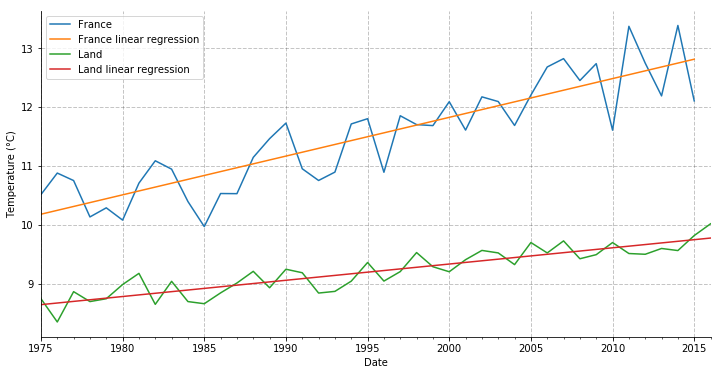

In [35]:
df_france.t.plot(figsize=(12, 6), label='France')
df_france.pred.plot(label='France linear regression')
df_land.t.plot(label='Land')
df_land.pred.plot(label='Land linear regression')
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
plt.legend()
sns.despine()

So over the last 40 years, France is getter hotter by 0.06583 degree per year in average, against 0.02759 degree for the globale land.